In [1]:
import torch
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
class DataProcessor():
    def __init__(self, particle_one, particle_two):
        super(DataProcessor,self).__init__()
        self.CLASS_ONE = particle_one
        self.CLASS_TWO = particle_two
        self.c1 = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/'+self.CLASS_ONE+'.hdf5', 'r')
        self.c2 = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/'+self.CLASS_TWO+'.hdf5', 'r') 
        self.gen_one = 'gen_'+particle_one
        self.gen_two = 'gen_'+particle_two
        self.gen_piplus = '/home/blazerjia/saved_output/RBM/piplus/18-13-51/synthetic_images_piplus.pt'
        self.gen_gamma = '/home/blazerjia/saved_output/unified/synthetic_images_gamma.pt'
        self.gen_eplus = '/home/blazerjia/saved_output/unified/synthetic_images_eplus.pt'
        self.gen_dict = {
            'gen_piplus': self.gen_piplus,
            'gen_gamma': self.gen_gamma,
            'gen_eplus': self.gen_eplus
        }
        
    def flattened_class_data(self, class_num):
        c_layer_0 = torch.tensor(np.array(class_num['layer_0']))
        c_layer_1 = torch.tensor(np.array(class_num['layer_1']))
        c_layer_2 = torch.tensor(np.array(class_num['layer_2']))
        c_flatten_0 = torch.flatten(c_layer_0, start_dim=1)
        c_flatten_1 = torch.flatten(c_layer_1, start_dim=1)
        c_flatten_2 = torch.flatten(c_layer_2, start_dim=1)
        flat_class_data = torch.cat((c_flatten_0,c_flatten_1,c_flatten_2), dim=1)
        return flat_class_data
    
    def get_synthetic_dataset(self):
        c1_dir = self.gen_dict[self.gen_one]
        c2_dir = self.gen_dict[self.gen_two]
        gen_c1_data = torch.load(c1_dir)
        gen_c2_data = torch.load(c2_dir)
        gen_c1_tensor = torch.cat(gen_c1_data).cpu()
        gen_c2_tensor = torch.cat(gen_c2_data).cpu()
        return gen_c1_tensor, gen_c2_tensor
          
    def get_geant_dataset(self):
        class_one_data = self.flattened_class_data(self.c1)
        class_two_data = self.flattened_class_data(self.c2)
        return class_one_data, class_two_data

In [3]:
# Load the gamma and eplus data for synthetic data and geant data separately.
dataloader =  DataProcessor('gamma', 'eplus')
gamma_syn, eplus_syn = dataloader.get_synthetic_dataset()
gamma_geant, eplus_geant = dataloader.get_geant_dataset()

In [4]:
# For 1 cell, if its mean energy value is lower than 'limit', we will remove this cell from the dataset for all events.
def mask_dataset(dataset, limit):
    dataset_mean = torch.mean(dataset, dim=0)
    dataset_mask = torch.where(dataset_mean < limit, torch.tensor(0), torch.tensor(1))
    indices = [i for i, x in enumerate(dataset_mask) if x == 1]
    print('The remaining cells left after masking:',indices)
    bool_mask = (dataset_mask == 1)
    dataset_processed = dataset[:,bool_mask]
    return dataset_processed, indices

In [5]:
gamma_syn.shape, eplus_syn.shape

(torch.Size([51200, 504]), torch.Size([51200, 504]))

In [6]:
gamma_syn_masked, indices_list = mask_dataset(gamma_syn, 100)
eplus_syn_masked, indices_list = mask_dataset(eplus_syn, 100)

The remaining cells left after masking: [141, 142, 143, 144, 145, 146, 340, 341, 342, 343, 352, 353, 354, 355, 364, 365, 366, 367, 376, 377, 378, 379]
The remaining cells left after masking: [141, 142, 143, 144, 145, 146, 340, 341, 342, 343, 352, 353, 354, 355, 364, 365, 366, 367, 376, 377, 378, 379]


In [7]:
gamma_syn_masked.shape, eplus_syn_masked.shape

(torch.Size([51200, 22]), torch.Size([51200, 22]))

In [8]:
def plot_cell_diff_ax(cell_id):
    gamma_syn_indexed=gamma_syn_masked[:,cell_id]
    eplus_syn_indexed=eplus_syn_masked[:,cell_id]
    ax.hist(gamma_syn_indexed, bins=50, color='blue', alpha=0.5, label='gamma', log=True)
    ax.hist(eplus_syn_indexed, bins=50, color='red', alpha=0.5, label='eplus', log=True)
    ax.legend()

Ploting cell at 0
Ploting cell at 1
Ploting cell at 2
Ploting cell at 3
Ploting cell at 4
Ploting cell at 5
Ploting cell at 6
Ploting cell at 7
Ploting cell at 8
Ploting cell at 9
Ploting cell at 10
Ploting cell at 11
Ploting cell at 12
Ploting cell at 13
Ploting cell at 14
Ploting cell at 15
Ploting cell at 16
Ploting cell at 17
Ploting cell at 18
Ploting cell at 19
Ploting cell at 20
Ploting cell at 21


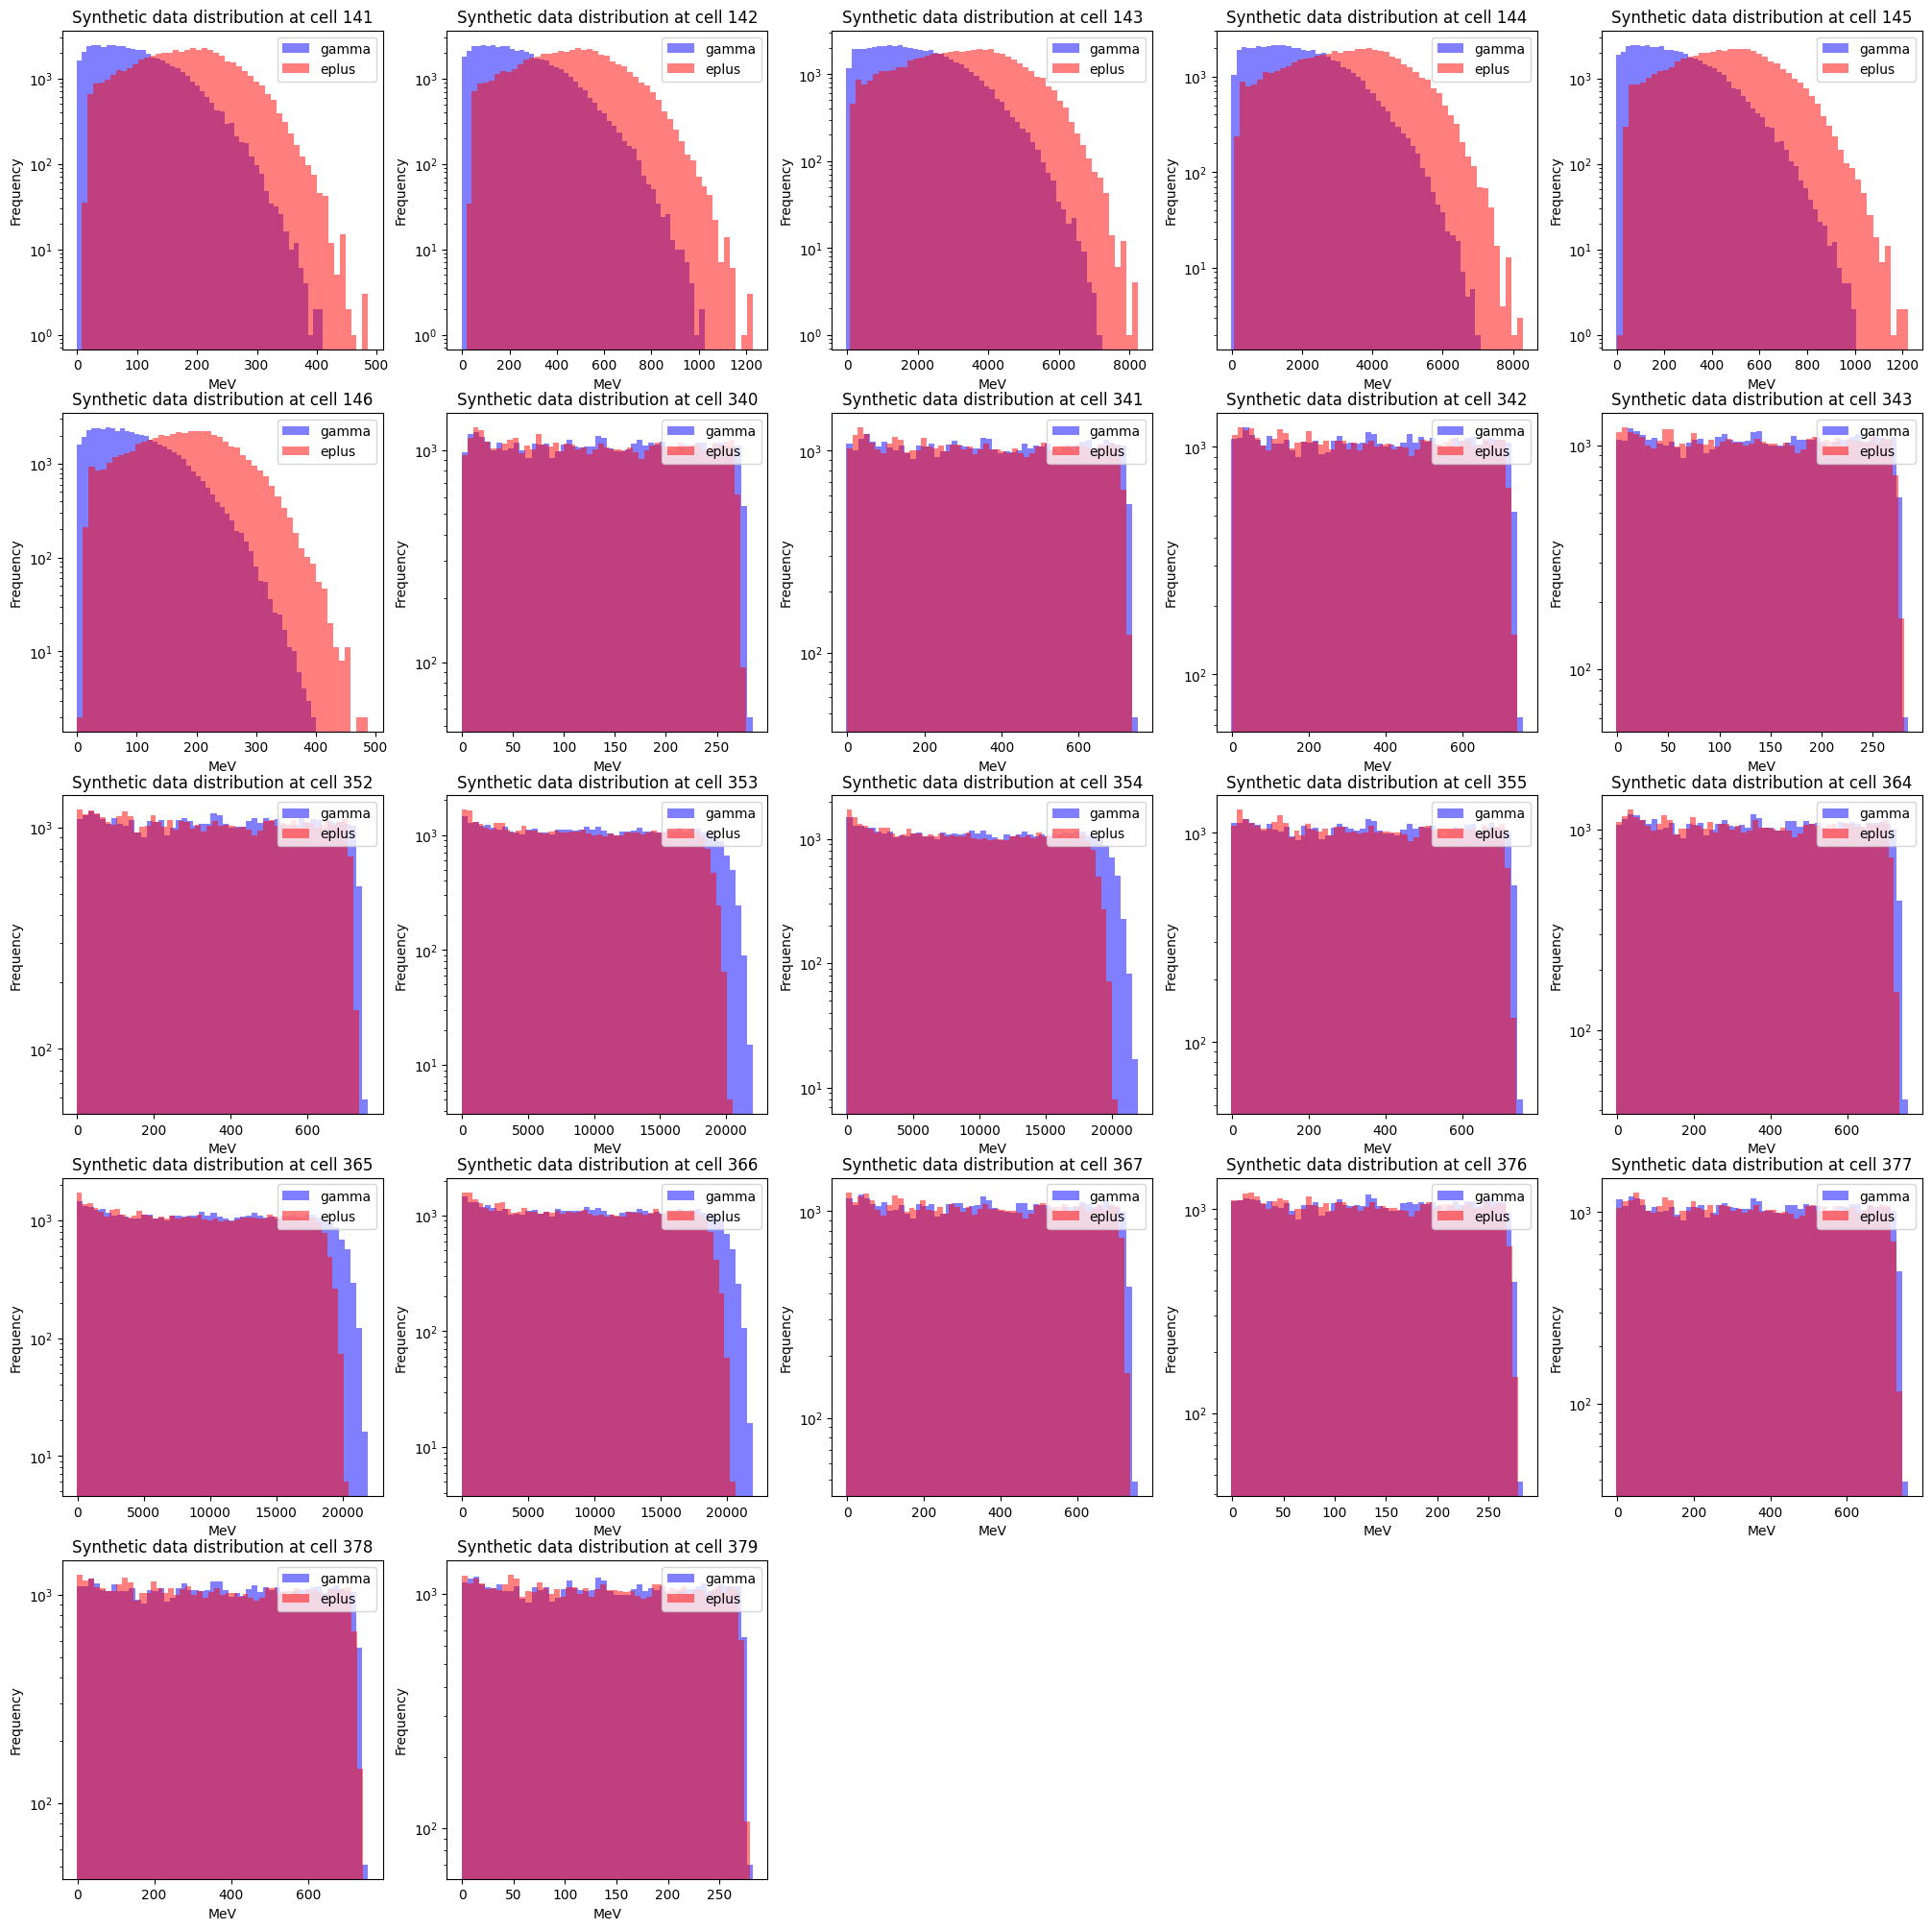

In [9]:

fig = plt.figure(figsize=(25, 25))
# Iterate through each subplot and plot the data
for i in range(1, 23):
    ax = fig.add_subplot(5, 5, i)
    cell_id=i-1
    print(f'Ploting cell at {cell_id}')
    plot_cell_diff_ax(cell_id)
    ax.set_title(f'Synthetic data distribution at cell {indices_list[cell_id]}')
    ax.set_xlabel('MeV')
    ax.set_ylabel('Frequency')